In [7]:
'''
TODO: PREPROCESSING
    - Generate masks from json files.
    - Add image_path, mask_path, json_path and background path to database.
    - Load them into list of tuples in the format of numpy array from database and shuffle.
    - Augment images and append to list.
    - Split into train and val data.
    - Train images using U-net segmentation model.
'''


'\nTODO: PREPROCESSING\n    - Generate masks from json files.\n    - Add image_path, mask_path, json_path and background path to database.\n    - Load them into list of tuples in the format of numpy array from database and shuffle.\n    - Augment images and append to list.\n    - Split into train and val data.\n    - Train images using U-net segmentation model.\n'

In [8]:
import os
import numpy as  np
import matplotlib.pyplot as plt
import json
import config
from matplotlib.path import Path
import cv2
from dataset import *
from model import *
from dataset.augment import *

tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

False

In [9]:
# tf_path = '/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out/best_128/auc_90.tflite'
# import tensorflow as tf
# interpreter = tf.lite.Interpreter(tf_path)
# interpreter.allocate_tensors()
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# img = train_ds[0][0]
# print(input_details)
# img = train_ds[0][0].astype(np.uint8).astype(np.float32)
# # print(img.dtype)
# img = cv2.resize(img, (128, 128))
# img = img.astype(np.uint8).astype(np.float32)



# interpreter.set_tensor(input_details[0]['index'], np.expand_dims(img, axis=0).reshape((1, 128, 128, 3)))

# # run model on interpreter
# interpreter.invoke()

# # retrive output
# output_data = interpreter.get_tensor(output_details[0]['index'])

# # print tflite output
# print('--- TFLite output ---')
# print(img)
# print('---------------------')

In [10]:
# img_index = 13
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(train_ds[0][0])
ax[1].imshow(np.squeeze(output_data))

NameError: name 'train_ds' is not defined

In [7]:
'''
Generate masks from json files and store in mask folder
# '''
# count = 0
# for file in os.listdir(config.IMAGE_DIRECTORY):
#     if file.split('.')[1] == 'json':
#         json_file = os.path.join(config.IMAGE_DIRECTORY, file) 
#         jpg_file = os.path.join(config.IMAGE_DIRECTORY, file.split('.')[0]+'.jpg')
#         generate_mask(jpg_file, json_file)


'\nGenerate masks from json files and store in mask folder\n# '

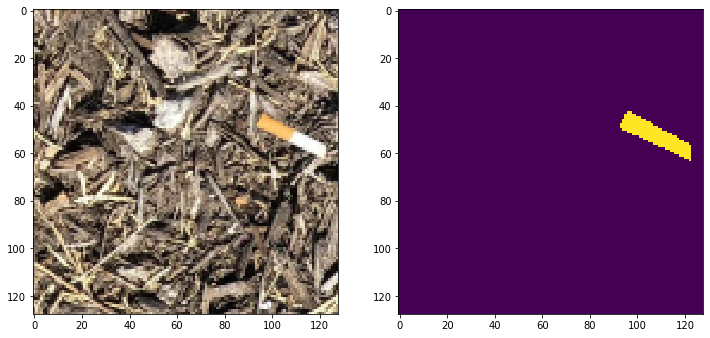

In [4]:
'''
Test with one image and mask
'''

json_files = os.listdir(config.MASK_DIRECTORY)
index = 180

mask_file = os.path.join(config.MASK_DIRECTORY, json_files[index])
jpg_file = mask_file.split('/')[-1].split('.')[0]
jpg_file = os.path.join(config.IMAGE_DIRECTORY, jpg_file+'.jpg')

img = plt.imread(jpg_file)
mask = np.load(mask_file)

img_resize = cv2.resize(img, dsize=(128, 128))
mask_resize = cv2.resize(mask, dsize=(128, 128))
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img_resize)
ax[1].imshow(mask_resize.astype(bool).astype(float))


['IMG_6564.jpg', '00000103.jpg', 'IMG_6567.jpg', '00000550.jpg', 'IMG_6331.jpg'] ['00000609.npy', '00000587.npy', 'IMG_20200306_164230.npy', 'IMG_6396.npy', 'IMG_20200307_164356.npy']


In [12]:
'''
Add to database
'''
db = Dataset(config.DB_PATH)
# for file in os.listdir(config.IMAGE_DIRECTORY):
#     extension = file.split('/')[-1].split('.')[-1]
#     file_name = file.split('/')[-1].split('.')[0]
#     if extension == 'json':
#         json_file = os.path.join(config.IMAGE_DIRECTORY, file)
#         jpg_file = os.path.join(config.IMAGE_DIRECTORY, file_name+'.jpg')
#         mask_file = os.path.join(config.MASK_DIRECTORY, file_name+'.npy') 
#         db.add_Paths(jpg_file, mask_file, json_file, db.con)




In [15]:
'''
Load paths to list in the format of tuples
'''
util = Utils(db.load_paths(db.con, 609)) # we have 609 images in database
train_ds = util.load_images()
random.shuffle(train_ds)

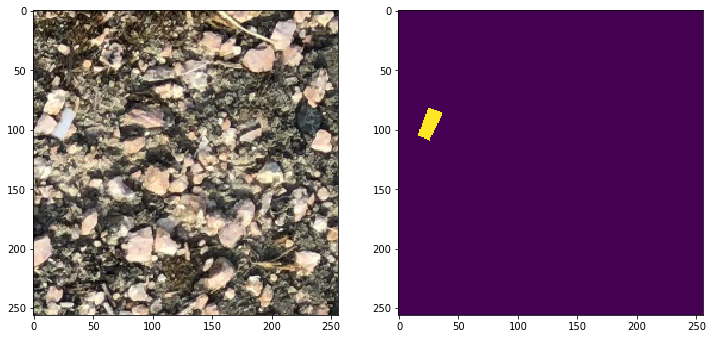

In [16]:
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(train_ds[0][0])
ax[1].imshow(train_ds[0][1])


In [17]:
'''fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(mask)

Augment train data
'''

def augment(tr_ds, init_step, nb_augment, augment_method):
    for count in range(nb_augment): 
        train_ds.append(augment_method(train_ds[init_step+count][0], train_ds[init_step+count][1]))    
    return train_ds

def over_bg_augment(tr_ds, init_step, nb_augment):
    bg_images = os.listdir(config.BACKGROUND_DIRECTORY)
    nb_images = len(os.listdir(config.BACKGROUND_DIRECTORY))
    
    for count in range(nb_augment):
        rnd = random.randint(0, nb_images - 1)
        bg_image = plt.imread(os.path.join(config.BACKGROUND_DIRECTORY, bg_images[rnd]))
        tr_ds.append(generate_img_over_bg(train_ds[init_step+count][0], train_ds[init_step+count][1], bg_image))
    return tr_ds

In [18]:
train_ds = augment(train_ds, 0, 200, flip_augment)
train_ds = augment(train_ds, 609, 1000, rotate_augment)
train_ds = over_bg_augment(train_ds, 0, 1000)

In [19]:
len(train_ds)

2809

In [20]:
resized_ds = list()

In [21]:
# cast to 128 * 128 pixel images
for i in range(len(train_ds)):
    img = cv2.resize(train_ds[i][0], dsize=(128, 128))
    mask = cv2.resize(train_ds[i][1], dsize=(128, 128))
    resized_ds.append((img, mask.astype(bool).astype(float)))

In [22]:
def view_img_mask(img, mask):
    fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
    ax[0].imshow(img)
    ax[1].imshow(mask)

In [23]:
import os
import sys
import time
import random
import pprint
from collections import OrderedDict

import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K



class CustomMetrics(Callback):
    def __init__(self, model, X_val, y_val, num_thresholds):
        super(CustomMetrics, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.num_thresholds = num_thresholds

    def on_epoch_end(self, epoch, logs={}):
        num_thresholds = self.num_thresholds
        thresholds = [(i + 1) * 1.0 / (num_thresholds - 1) for i in range(num_thresholds - 2)]
        custom_val_metrics = list()

        y_pred = tf.reshape(self.model.predict(self.X_val), [-1])
        y_true = tf.reshape(self.y_val, [-1])

        for thresh in thresholds:
            pred_classes = tf.cast(tf.math.greater(y_pred, tf.constant([thresh])), dtype=tf.float32)
            cm = tf.math.confusion_matrix(y_true, pred_classes, num_classes=2)

            tn = cm[0][0].numpy()
            fp = cm[0][1].numpy()
            fn = cm[1][0].numpy()
            tp = cm[1][1].numpy()

            precision = tp / (tp + fp + K.epsilon())
            recall = tp / (tp + fn + K.epsilon())
            f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

            payload = \
                OrderedDict([('val_auc', logs.get('val_auc')),
                             ('val_f1', f1),
                             ('precision', precision),
                             ('recall', recall),
                             ('val_tp', tp),
                             ('val_tn', tn),
                             ('val_fp', fp),
                             ('val_fn', fn),
                             ('thresh', thresh)])

            custom_val_metrics.append(payload)
        best_val_f1 = sorted(custom_val_metrics, key=lambda x: x['val_f1'], reverse=True)[0]
        pprint.pprint(best_val_f1)

        

In [24]:
def downsample(x, dconvs, depth,  kernel_size = [(7, 7) , (5, 5) , (5, 5) , (3, 3)]):
    start_filter = 16
    drop_rate = 0.3
    k_init = tf.initializers.glorot_normal(seed=313)
    b_init = tf.initializers.glorot_normal(seed=313)
    i = 0
    for i in range(depth):
        x = Conv2D(filters=start_filter * np.power(2, i), kernel_size= kernel_size[i], strides=1, padding='same',
                            activation='relu', kernel_initializer=k_init, bias_initializer=b_init,
                            name=f'dconv_1_level_{i}')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=start_filter * np.power(2, i) , kernel_size=kernel_size[i], strides=1, padding='same',
                            activation='relu', kernel_initializer=k_init, bias_initializer=b_init,
                            name=f'dconv_2_level_{i}')(x)
        x = BatchNormalization()(x)
        dconvs.append(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(drop_rate, seed=313)(x)
    return x, dconvs

def bottleneck(x , depth):
    drop_rate = 0.3
    k_init = tf.initializers.glorot_normal(seed=313)
    b_init = tf.initializers.glorot_normal(seed=313)
    start_filter = 16
    convm_1 = Conv2D(filters=start_filter * np.power(2, depth), kernel_size=(3, 3), strides=1, padding='same',
                     activation='relu', kernel_initializer=k_init, bias_initializer=b_init, name='convm_1')(x)
    convm_2 = Conv2D(filters=start_filter * np.power(2, depth), kernel_size=(3, 3), strides=1, padding='same',
                     activation='relu', kernel_initializer=k_init, bias_initializer=b_init, name='convm_2')(convm_1)
   
    return convm_2

def Upsample(x, dconvs, depth, kernel_size = [(3, 3), (5, 5), (5, 5), (7, 7)]):
    start_filter = 16
    drop_rate = 0.3
    k_init = tf.initializers.glorot_normal(seed=313)
    b_init = tf.initializers.glorot_normal(seed=313)
    for i in range(depth - 1, -1, -1):
        deconv = Conv2DTranspose(start_filter * np.power(2, i), kernel_size=kernel_size[i], strides=(2, 2), padding="same",
                                 kernel_initializer=k_init, bias_initializer=b_init, name=f'deconv_level_{i}')(x)
        
        # deconv = UpSampling2D((2,2) , interpolation='bilinear')(x)
        x = concatenate([deconv, dconvs.pop()], name=f'concat_level_{i}')
        x = Dropout(drop_rate, seed=313)(x)
        x = Conv2D(start_filter * np.power(2, i),kernel_size=kernel_size[i], activation="relu", padding="same",
                kernel_initializer=k_init, bias_initializer=b_init, name=f'uconv_1_level_{i}')(x)
        x = BatchNormalization()(x)
        x = Conv2D(start_filter * np.power(2, i) ,kernel_size=kernel_size[i], activation="relu", padding="same",
                kernel_initializer=k_init, bias_initializer=b_init, name=f'uconv_2_level_{i}')(x)
        x = BatchNormalization()(x)
       
    return x


In [25]:

def get_model(data, name="UNET-BASE", **params):
    def _get_log_weight_dirs(name, dt):
        _dt = dt.strftime("%Y_%m_%d_T%H_%M_%S")
        relative_dt_dir = os.path.join(name, _dt)
        dt_dir = os.path.join(config.MODEL_OUT_DIR, relative_dt_dir)
        return os.path.join(dt_dir, 'logs'), os.path.join(dt_dir, 'weights')


    start_filter = params.get('START_FILTER')
    middle_filter = params.get('MIDDLE_FILTERS')
    drop_rate = params.get('DROP_RATE')
    epochs = params.get('EPOCHS')
    batch_size = params.get('BATCH_SIZE')
    num_thresholds = params.get('NUM_THRESHOLDS')

    MODEL_OUT = '/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out'
    assert np.mod(np.log2(start_filter), 1) == 0.0
    assert np.mod(np.log2(middle_filter), 1) == 0.0
    assert middle_filter >= start_filter

    depth = np.int(np.log2(middle_filter) - np.log2(start_filter))
    
    (tr_ds, mask_ds),(val_ds, val_mask_ds) = split_train_val(data)
    
    
    X_train = tf.cast(np.array(tr_ds), tf.float32)
    y_train = tf.cast(mask_ds, tf.float32)
    X_val = tf.cast(np.array(val_ds), tf.float32)
    y_val = tf.cast(val_mask_ds, tf.float32)


    input_channels = X_train.shape[-1]
    output_channels = y_train.shape[-1]

    weight_dir = MODEL_OUT
    log_dir = MODEL_OUT
    weight_path = str(os.path.join(weight_dir, 'weight.h5'))

    inputs = Input(shape=(128, 128, 3), name="inputs")
    temp = Lambda(lambda x: x / config.IMG_MAX_VAL, name="normalize")(inputs)

    k_init = tf.initializers.glorot_normal(seed=313)
    b_init = tf.initializers.glorot_normal(seed=313)
    dconvs = list()

    x, dconvs = downsample(temp, dconvs, depth)
    x = bottleneck(x, depth)
    x = Upsample(x, dconvs, depth)


    outputs = Conv2D(output_channels,(1, 1), padding="same", activation="sigmoid", kernel_initializer=k_init,
                     bias_initializer=b_init, name="outputs")(x)


    model = Model(inputs=inputs, outputs=outputs)


    auc = AUC(num_thresholds=num_thresholds, curve='PR', name='auc')
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[auc])

    tensorboard_callback = TensorBoard(log_dir, histogram_freq=1)
    early_stopping = EarlyStopping(patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    model_checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
    custom_metrics = CustomMetrics(model, X_val, y_val, num_thresholds)

    history = model.fit(X_train, y_train,
                        validation_data=[X_val, y_val],
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[model_checkpoint, reduce_lr, custom_metrics, tensorboard_callback],
                        shuffle=False,
                        verbose=1)

    model.load_weights(weight_path)


    return history, model


In [28]:
def split_train_val(data):
    '''
    Splitting the data into train and validation set for u-net segmentation model.
    Args: 
        data
    Returns:
        (tr_ds, mask_ds), (val_ds, mask_val_ds)
    '''
    def _split(data, init_step, len_new):
        x_ds, y_ds = list(), list()
        for i in range(len_new):
            x_ds.append(data[i + init_step][0])
            y_ds.append(data[i + init_step][1])
        y_ds = np.array(y_ds).reshape(len_new, 128, 128, 1)

        return x_ds, y_ds
        

    data_len = len(data)
    tr_len = int(data_len * 0.75)
    val_len = data_len - tr_len

    tr_ds, mask_ds = _split(data, 0, tr_len)
    val_ds, val_mask_ds = _split(data, tr_len, val_len)
    
    return (tr_ds, mask_ds), (val_ds, val_mask_ds)




In [29]:
(tr, mask),(val, val_mask) = split_train_val(resized_ds)

In [30]:
len(val_mask)

703

In [25]:

UNET_CONFIG = {
    'START_FILTER': 16,
    'MIDDLE_FILTERS': 256,
    'DROP_RATE': 0.3,
    'EPOCHS': 30,
    'BATCH_SIZE': 32,
    'NUM_THRESHOLDS': 50
}


base_model = get_model(resized_ds, **UNET_CONFIG)
# dt = np.array(train_ds[0][0])

 0.8979591836734694)])
2106/2106 [==============================] - 564s 268ms/sample - loss: 0.2224 - auc: 0.4899 - val_loss: 0.6988 - val_auc: 0.2052
Epoch 2/30
2080/2106 [============================>.] - ETA: 6s - loss: 0.1438 - auc: 0.6857
Epoch 00002: val_loss improved from 0.69878 to 0.13899, saving model to /home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out/weight.h5
OrderedDict([('val_auc', 0.4701106),
             ('val_f1', 0.4941476491123382),
             ('precision', 0.6200452556511603),
             ('recall', 0.41074721720443225),
             ('val_tp', 86864),
             ('val_tn', 11253245),
             ('val_fp', 53229),
             ('val_fn', 124614),
             ('thresh', 0.24489795918367346)])
2106/2106 [==============================] - 578s 275ms/sample - loss: 0.1434 - auc: 0.6873 - val_loss: 0.1390 - val_auc: 0.4701
Epoch 3/30
2080/2106 [============================>.] - ETA: 5s - loss: 0.0934 - auc: 0.7782
Epoch 00003: val_loss 

In [31]:

from tensorflow.keras.models import load_model
# model = load_model('model.h5')# base_model[1].save('auc_90.h5')
base_model = load_model('/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out/model.h5')

In [27]:

def view_img_mask(img, mask, thres_val, model=False):
    if model:
        pred = model.predict(np.expand_dims(img, axis=0)).reshape((1, img.shape[0], img.shape[1], 1))
        pred = np.squeeze(pred)
        fig, ax = plt.subplots(1 , 3, figsize=(18, 8))
        ax[0].imshow(img)
        ax[1].imshow(mask)
        ax[2].imshow(pred > thres_val)
    else:
        fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
        ax[0].imshow(img)
        ax[1].imshow(mask)

img_index = 10

# view_img_mask(train_ds[img_index][0], train_ds[img_index][1], base_model)
view_img_mask(val[img_index], val_mask[img_index].reshape(128, 128), 0.38 , base_model[1])

# print(train_ds[img_index][1])
# print(mask[img_index])

NameError: name 'val' is not defined

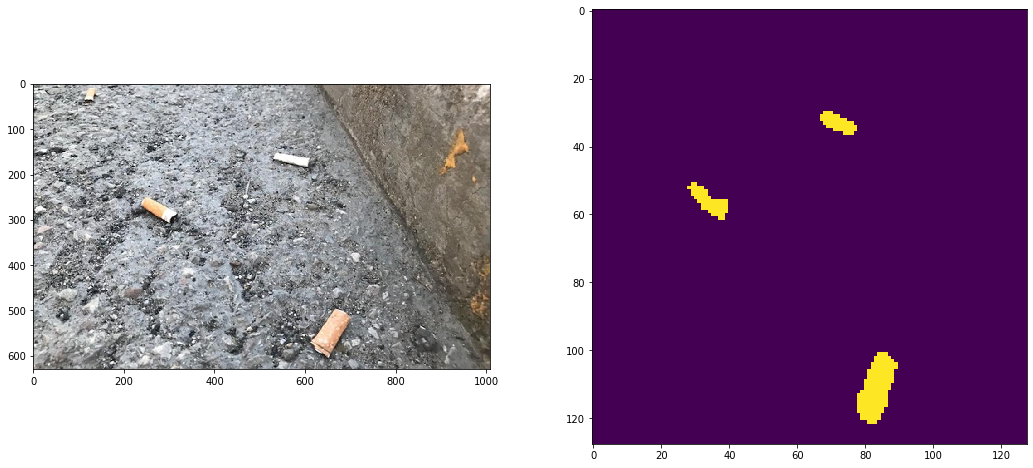

In [37]:
# predict on a test image
img_real = plt.imread('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/test/test-17.jpg')
img = cv2.resize(img_real, (128, 128))
pred = base_model.predict(np.expand_dims(img, axis=0)).reshape((1, 128, 128, 1))
pred = np.squeeze(pred)
# cv2.imwrite('pred_test_2.jpg', (pred > 0.38).astype(float) *255 )
fig, ax = plt.subplots(1 , 2, figsize=(18, 8))
ax[0].imshow(img_real)
ax[1].imshow(pred > 0.34)

In [57]:
def predict_img(img_path, thres_val):
    # img = plt.imread('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/test-9.jpg')
    # resize_image('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test')
    img = plt.imread(img_path)
    img_resized = cv2.resize(img, (128, 128))
    pred = base_model.predict(np.expand_dims(img_resized, axis=0)).reshape((1, 128, 128, 1))
    pred = np.squeeze(pred)
    fig, ax = plt.subplots(1 , 2, figsize=(18, 8))
    ax[0].imshow(img)
    ax[1].imshow(pred > thres_val)
    fig.savefig('/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/test_examples/img2.png')

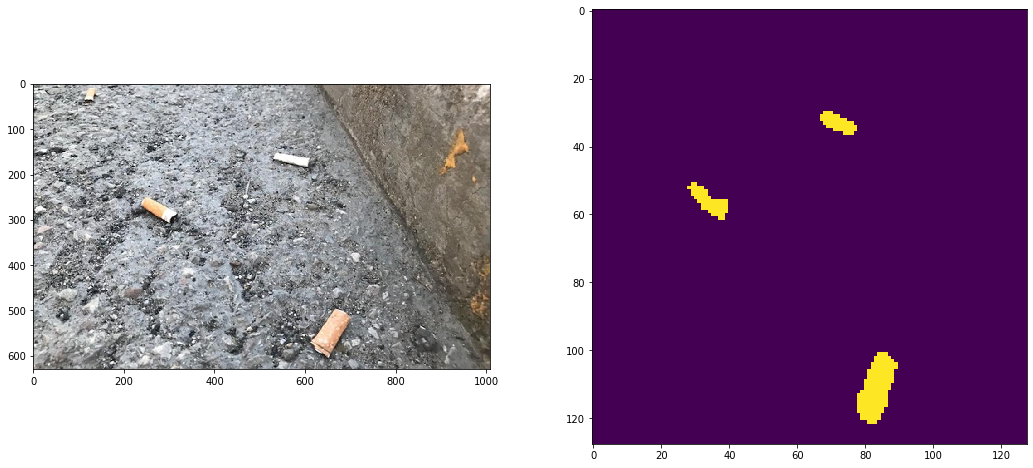

In [58]:
import cv2
predict_img('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/test/test-17.jpg', 0.34)


In [2]:
def video_predict(file_path, model, thresh_val):
    '''
    Read video and predict on each frame.
    Args:
        filename(str)
    '''
    def getFrame(sec , img_mask_ds):

        WIDTH, HEIGHT = 128, 128
        video_path = '/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/video_test'
        vidcap = cv2.VideoCapture(file_path)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            image_real = image
            image = cv2.resize(image, (WIDTH, HEIGHT))
            pred_img = base_model.predict(np.expand_dims(image, axis=0)).reshape((1, WIDTH, HEIGHT, 1))
            pred_img = np.squeeze(pred_img)
            # cv2.imwrite(os.path.join(video_path,"pred_image"+str(count)+".jpg"), (pred_img > thresh_val).astype(float)*255)
            # # cv2.imwrite(os.path.join(video_path,"image"+str(count)+".jpg"), image)
            # cv2.imwrite(os.path.join(video_path,"image_real"+str(count)+".jpg"), image_real)
            img_mask_ds.append((image, (pred_img > thresh_val).astype(float)*255))

        return hasFrames, img_mask_ds

    img_mask_ds = list()
    sec = 0
    frameRate = 0.5 #//it will capture image in each 0.5 second
    count = 1
    success = getFrame(sec, img_mask_ds)
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success, img_mask_ds = getFrame(sec, img_mask_ds)

    return img_mask_ds



In [49]:
img_mask_ds = video_predict('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/IMG_9429.mp4', base_model , 0.44)

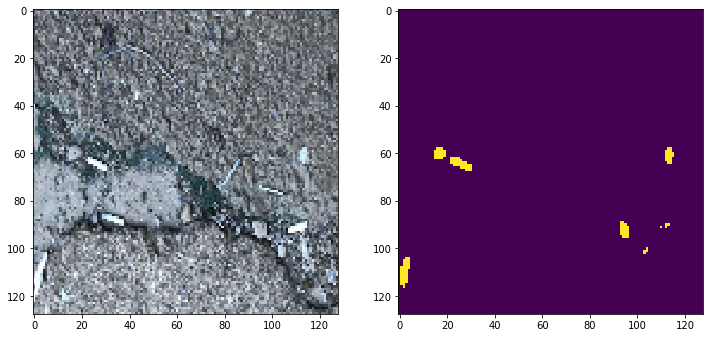

In [88]:
img_index = 13
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img_mask_ds[img_index][0])
ax[1].imshow(img_mask_ds[img_index][1])


In [7]:
import tensorflow as tf
mdoel_path = '/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out/best_128/auc_90.h5'
model = tf.keras.models.load_model(mdoel_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out/best_128/auc_90.tflite", "wb").write(tflite_model)

23949540

In [3]:

import cv2
from tensorflow.keras.models import load_model


def predict_img(img_path, thres_val):
    # img = plt.imread('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/test-9.jpg')
    # resize_image('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test')
    img = plt.imread(img_path)
    img = cv2.resize(img, (128, 128))
    pred = base_model.predict(np.expand_dims(img, axis=0)).reshape((1, 128, 128, 1))
    pred = np.squeeze(pred)
    fig, ax = plt.subplots(1 , 2, figsize=(18, 8))
    ax[0].imshow(img)
    ax[1].imshow(pred > thres_val)

def video_predict(file_path, model, thresh_val):
    '''
    Read video and predict on each frame.
    Args:
        filename(str)
    '''
    def getFrame(sec , img_mask_ds):

        WIDTH, HEIGHT = 128, 128
        video_path = '/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/video_test'
        vidcap = cv2.VideoCapture(file_path)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            image_real = image
            image = cv2.resize(image, (WIDTH, HEIGHT))
            pred_img = base_model.predict(np.expand_dims(image, axis=0)).reshape((1, WIDTH, HEIGHT, 1))
            pred_img = np.squeeze(pred_img)
            # cv2.imwrite(os.path.join(video_path,"pred_image"+str(count)+".jpg"), (pred_img > thresh_val).astype(float)*255)
            # # cv2.imwrite(os.path.join(video_path,"image"+str(count)+".jpg"), image)
            # cv2.imwrite(os.path.join(video_path,"image_real"+str(count)+".jpg"), image_real)
            img_mask_ds.append((image, (pred_img > thresh_val).astype(float)*255))

        return hasFrames, img_mask_ds

    img_mask_ds = list()
    sec = 0
    frameRate = 0.5 #//it will capture image in each 0.5 second
    count = 1
    success = getFrame(sec, img_mask_ds)
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success, img_mask_ds = getFrame(sec, img_mask_ds)

    return img_mask_ds


base_model = load_model('/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out/best_128/auc_90.h5')
# predict_img('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/test/test-33.jpg', 0.44)

In [13]:
img_mask_ds = video_predict('/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/cigar_test.mp4', base_model , 0.44)

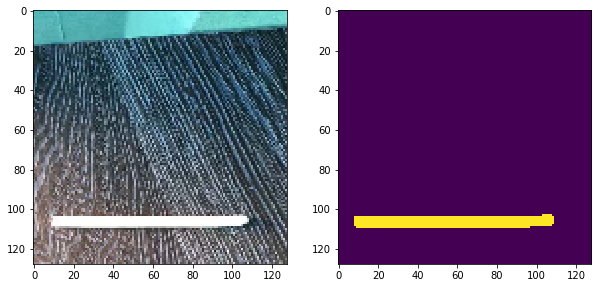

In [31]:
img_index = 11
img = img_mask_ds[img_index][0]
mask = img_mask_ds[img_index][1]
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(img)
axs[1].imshow(mask)